In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import ipdb
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
pkl_file = open("./human_aware_rl/human_aware_rl/static/human_data/cleaned/2020_hh_trials_train.pickle", "rb")
df = pickle.load(pkl_file)

In [3]:
df[df.index == 104706]

,state,joint_action,reward,time_left,score,time_elapsed,cur_gameloop,layout,layout_name,trial_id,player_0_id,player_1_id,player_0_is_human,player_1_is_human,cur_gameloop_total,score_total,button_press,button_press_total,timesteps_since_interact,button_presses_per_timstep
104706,"{""players"": [{""position"": [6, 2], ""orientation...","[[0, 0], [0, 0]]",0,59.836342,0,0.163659,1,"[[""X"", ""T"", ""X"", ""X"", ""X"", ""X"", ""X"", ""O"", ""X""]...",asymmetric_advantages_tomato,A107RJSS561Y7R:3Q5ZZ9ZEVTMZAGUKW8V7VOFCWDI85G1...,e1dfeca129874236befaad8d9e481a3e,6e1413b2cb8544c59eb22023619f2e1a,True,True,396,141,0,266,3,0.671717


In [4]:
trial_id = df.trial_id.unique()[0]

In [5]:
trial_data = df[df.trial_id == trial_id]

In [6]:
trial_data.shape

(396, 20)

In [7]:
trial_data = trial_data.sort_values('cur_gameloop')

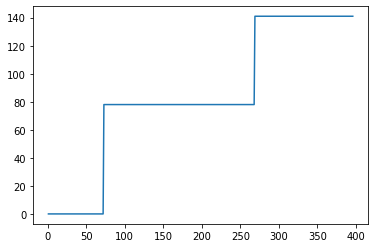

In [8]:
plt.plot(trial_data.cur_gameloop, trial_data.score)

In [9]:
action_dict = {(0, 0): 0, (0, 1): 1, (1, 0): 2, (0, -1): 3, (-1, 0): 4, "interact": 5}
def extract_player_actions(trial_data, player=0):
    all_actions = trial_data.sort_values('cur_gameloop').joint_action.tolist()
    player_actions = [eval(t)[player] for t in all_actions]
    # convert actions to a set of integers
    player_actions = [action_dict[tuple(a)] if type(a) == list else action_dict[a] for a in player_actions]
    return player_actions

In [10]:
player0_actions = extract_player_actions(trial_data, 1)

In [11]:
NUM_ACTIONS = 6
def entropy(dist):
    return -np.sum(dist * np.log(dist))
def entropy_traj(action_traj):
    action_dist = np.zeros(NUM_ACTIONS)
    entropy_traj = np.zeros(len(action_traj))
    for idx, a in enumerate(action_traj):
        action_dist[a] += 1
        entropy_traj[idx] = entropy(action_dist / np.sum(action_dist))
    return entropy_traj

In [12]:
e_traj = entropy_traj(player0_actions)

<ipython-input-11-66d399b74ac3>:3: RuntimeWarning: divide by zero encountered in log
  return -np.sum(dist * np.log(dist))
<ipython-input-11-66d399b74ac3>:3: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(dist * np.log(dist))


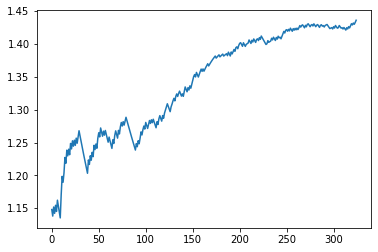

In [13]:
plt.plot(e_traj[~np.isnan(e_traj)])

In [14]:
state_dict = json.loads(trial_data.state.unique()[100])

In [15]:
state_dict['objects']

[{'name': 'onion', 'position': [2, 1]},
 {'name': 'dish', 'position': [2, 4]},
 {'name': 'soup',
  'position': [4, 2],
  '_ingredients': [{'name': 'onion', 'position': [4, 2]},
   {'name': 'onion', 'position': [4, 2]}],
  'cooking_tick': 1,
  'is_cooking': True,
  'is_ready': False,
  'is_idle': False,
  'cook_time': 30,
  '_cooking_tick': 1}]

In [20]:
def time_waiting(action_traj):
    # TODO: make this a moving average
    k = 20 # moving average window size
    action_dist = np.zeros(NUM_ACTIONS)
    time_waiting = np.zeros(len(action_traj))
    prev_k_is_wait = np.zeros(k)
    for idx, a in enumerate(action_traj):
        action_dist[a] += 1
        prev_k_is_wait = np.roll(prev_k_is_wait) # TODO: finish
        if idx < k:
            time_waiting[idx] = action_dist[0] / (idx+1)
        else:
            time_waiting[idx] = np.mean(prev_k_is_wait)
    return time_waiting

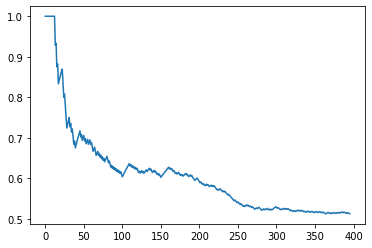

In [21]:
tw = time_waiting(player0_actions)
plt.plot(tw)